In [1]:
!pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.7 MB 7.2 MB/s 
     |████████████████████████████████| 19.2 MB 368 kB/s 
     |████████████████████████████████| 240 kB 85.8 MB/s 
     |████████████████████████████████| 112 kB 67.3 MB/s 
     |████████████████████████████████| 55 kB 2.5 MB/s 
     |████████████████████████████████| 49 kB 8.0 MB/s 
     |████████████████████████████████| 1.6 MB 21.5 MB/s 
     |████████████████████████████████| 943 kB 62.0 MB/s 
     |████████████████████████████████| 37.5 MB 51 kB/s 
     |████████████████████████████████| 49 kB 6.7 MB/s 
     |████████████████████████████████| 4.0 MB 55.8 MB/s 
     |████████████████████████████████| 112 kB 66.7 MB/s 
  Created wheel for qiskit: filename=qiskit-0.38.0-py3-none-any.whl size=12147 sha256=accbd2b36d8a5b6d2c4419ef295b96c401eed2f4c780b0c7e45cacbce86f0921
  Stored in directory: /root/.cache/pip/wheels/0b/30/78/04c91b

In [2]:
import pandas as pd
#from pennylane 
import numpy as np
import matplotlib.pyplot as plt

import copy

from qiskit import Aer
#from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, TwoLocal
#from qiskit.circuit import ParameterVector
#from qiskit.utils import QuantumInstance
#from qiskit_machine_learning.algorithms import QSVC
from qiskit.algorithms.optimizers import SPSA
#from qiskit_machine_learning.kernels import QuantumKernel
#from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
#from sklearn.decomposition import PCA

from qiskit import QuantumCircuit, assemble
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.circuit import Parameter

#from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

#from functools import reduce

#import pennylane as qml

#from pylab import cm

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams['font.size'] = 20

Setup

In [3]:
N = 9
x = np.linspace(0,1,N+1)
y = (-1)**np.linspace(0,N,N+1)

In [4]:
sim = Aer.get_backend('aer_simulator')

In [5]:
def qubit_map(phi):
    qc = QuantumCircuit(1)
    qc.h(0)
    qc.p(phi, 0)
    qc.h(0)
    return(qc)

In [6]:
qc1 = qubit_map(np.pi)
qc2 = qubit_map(-np.pi)
qc = qc1.compose(qc2)
#qc.draw(output = 'mpl')

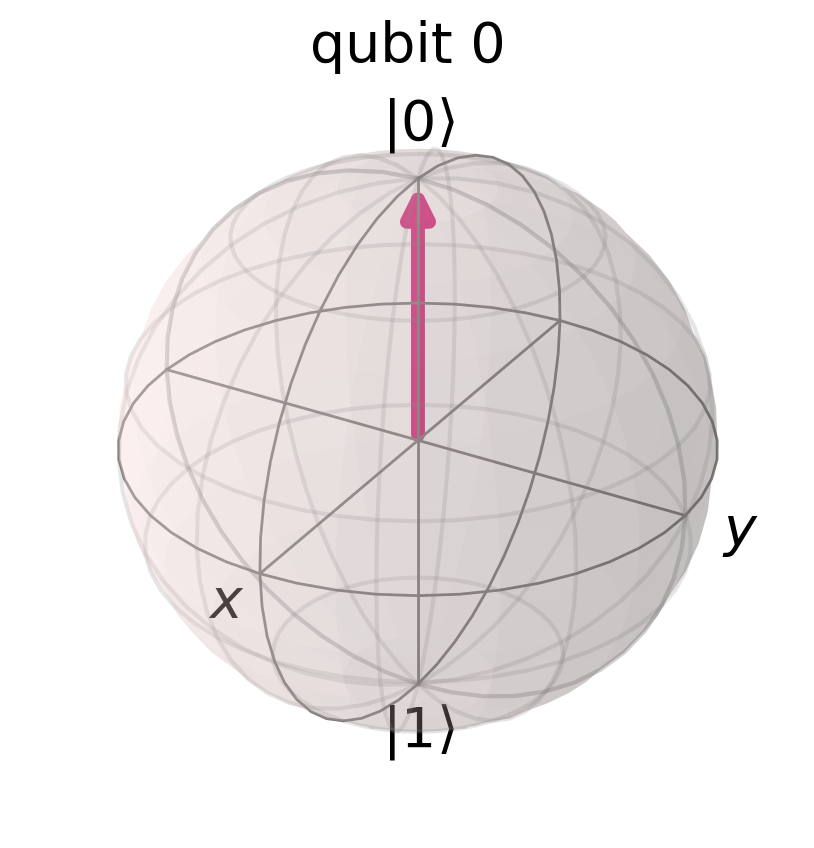

In [7]:
qc.save_statevector()
qobj = assemble(qc)
state = sim.run(qobj).result().get_statevector()
plot_bloch_multivector(state)

In [8]:
def kernel_map():
    x1 = Parameter('x1')
    x2 = Parameter('x2')
    phi = Parameter('Φ')
    qc = QuantumCircuit(1,1)
    qc.h(0)
    qc.p(phi*x1, 0)
    qc.p(-1.0*phi*x2,0)
    qc.h(0)
    qc.measure(0, 0)
    return(x1, x2, phi, qc)

In [9]:
#x1 = Parameter('x1')
#x2 = Parameter('x2')
#phi = Parameter('Φ')
#qc_out = kernel_map_old(x1,x2,phi)
#qc_out.draw(output = 'mpl')

In [10]:
def get_kernel_entry(qc, x1, x1_value, x2, x2_value, phi, phi_value, sim = Aer.get_backend('aer_simulator')): #, x1 = Parameter('x1'), x2 =  Parameter('x2'), phi = Parameter('Φ')
    qc_bound = qc.bind_parameters({x1:float(x1_value), x2:float(x2_value), phi:float(phi_value)})
    qobj = assemble(qc_bound)  # Assemble circuit into a Qobj that can be run
    counts = sim.run(qobj).result().get_counts()  # Do the simulation, returning the state vector
    if(counts.get('0')):
        kernel_element = counts.get('0')/(sum(counts[item] for item in counts))
    else:
        kernel_element = 0
    return(kernel_element)

In [11]:
x1, x2, phi, qc_test = kernel_map()
#qc_test.bind_parameters({x1:0, x2:0, phi:1})

In [12]:
get_kernel_entry(qc= qc_test, x1= x1, x1_value=0, x2= x2, x2_value= 0.1, phi= phi, phi_value=1)

0.9951171875

In [13]:
#x1 = Parameter('x1')
#x2 = Parameter('x2')
#phi = Parameter('Φ')
#qc_out = kernel_map_old(x1,x2,phi)
#x1_value = x[0]
#x2_value = x[1]
#get_kernel_entry_old(qc= qc_out, x1_value= x1_value, x2_value= x2_value, phi_value= np.pi)

In [14]:
#x1_value = x[0]
#x2_value = x[1]
#get_kernel_entry_old(qc= qc_out, x1_value= x1_value, x2_value= x2_value, phi_value= np.pi)

In [15]:
def get_kernel(x, phi_value):
    x1, x2, phi, qc_out = kernel_map()
    #return(qc_out.draw(output='mpl'))
    kernel = np.zeros((len(x),len(x)))
    for i in range(len(x)):
        for j in range(i):
            x1_value = x[i]
            x2_value = x[j]
            #print("x1: ", x1_value, "x2: ", x2_value)
            kernel[i,j] = get_kernel_entry(qc= qc_out, x1= x1, x1_value= x1_value, x2= x2, x2_value= x2_value, phi= phi, phi_value = phi_value)
    kernel = kernel+np.transpose(kernel) + np.identity(len(x))
    return(kernel)

In [16]:
get_kernel(x, np.pi)

array([[1.        , 0.97753906, 0.89160156, 0.72460938, 0.55761719,
        0.40332031, 0.265625  , 0.11621094, 0.0234375 , 0.        ],
       [0.97753906, 1.        , 0.96679688, 0.87890625, 0.73339844,
        0.58496094, 0.42285156, 0.25      , 0.1171875 , 0.03222656],
       [0.89160156, 0.96679688, 1.        , 0.9765625 , 0.87792969,
        0.7421875 , 0.58984375, 0.39648438, 0.23828125, 0.11425781],
       [0.72460938, 0.87890625, 0.9765625 , 1.        , 0.97070312,
        0.87792969, 0.76757812, 0.55859375, 0.39550781, 0.22949219],
       [0.55761719, 0.73339844, 0.87792969, 0.97070312, 1.        ,
        0.96679688, 0.890625  , 0.77734375, 0.59082031, 0.4140625 ],
       [0.40332031, 0.58496094, 0.7421875 , 0.87792969, 0.96679688,
        1.        , 0.97070312, 0.87890625, 0.76367188, 0.58789062],
       [0.265625  , 0.42285156, 0.58984375, 0.76757812, 0.890625  ,
        0.97070312, 1.        , 0.9609375 , 0.89160156, 0.74902344],
       [0.11621094, 0.25      , 0.3964843

In [17]:
#initial_point = [np.random.random(qc_out_data.num_parameters)]
#spsa = SPSA(maxiter=300)
#result = spsa.optimize(ansatz.num_parameters, loss, initial_point=initial_point, callback=cb_qkt.callback)

In [18]:
def matrix_target_alignment(K, Y, rescale_class_labels=True):
    if rescale_class_labels:
        nplus = np.count_nonzero(np.array(Y) == 1)
        nminus = len(Y) - nplus
        _Y = np.array([y / nplus if y == 1 else y / nminus for y in Y])
    else:
        _Y = np.array(Y)

    T = np.outer(_Y, _Y)
    inner_product = np.sum(K * T)
    norm = np.sqrt(np.sum(K * K) * np.sum(T * T))
    inner_product = inner_product / norm

    return inner_product

In [19]:
matrix_target_alignment(get_kernel(x, np.pi), y)

0.0079299688590938

In [20]:
matrix_target_alignment(get_kernel(x, N*np.pi), y)

0.7071067811865477

Single optimization run

In [21]:
def loss(phi_val):
    return( - matrix_target_alignment(get_kernel(x, phi_val), y))


In [22]:
class QKTCallback:
    """Callback wrapper class."""

    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        """
        Args:
            x0: number of function evaluations
            x1: the parameters
            x2: the function value
            x3: the stepsize
            x4: whether the step was accepted
        """
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]

In [23]:
cb_qkt = QKTCallback()
initial_point = [0.85*np.pi*N]
spsa = SPSA(maxiter=20, callback=cb_qkt.callback, learning_rate=10.0, perturbation=1.0)
result = spsa.optimize(1, loss, initial_point=initial_point)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The SPSA.optimize method is deprecated as of Qiskit Terra 0.21.0 and will be removed no sooner than 3 months after the release date. Instead, use SPSA.minimize as a replacement, which supports the same arguments but follows the interface of scipy.optimize and returns a complete result object containing additional information.
  after removing the cwd from sys.path.


In [24]:
callback = cb_qkt.get_callback_data()
TA = callback[2]
param = callback[1]

In [25]:
print("Starting parameter: ", initial_point[0], "\nEnd parameter: ", param[-1], "\nIdeal value: ", np.pi*N, "\nLoss: ", TA[-1] , "\nIdeal loss: ", loss(np.pi*N))
param[-1]

Starting parameter:  24.03318379996192 
End parameter:  [28.27453258] 
Ideal value:  28.274333882308138 
Loss:  -0.7071067811865477 
Ideal loss:  -0.7071067811865477


array([28.27453258])

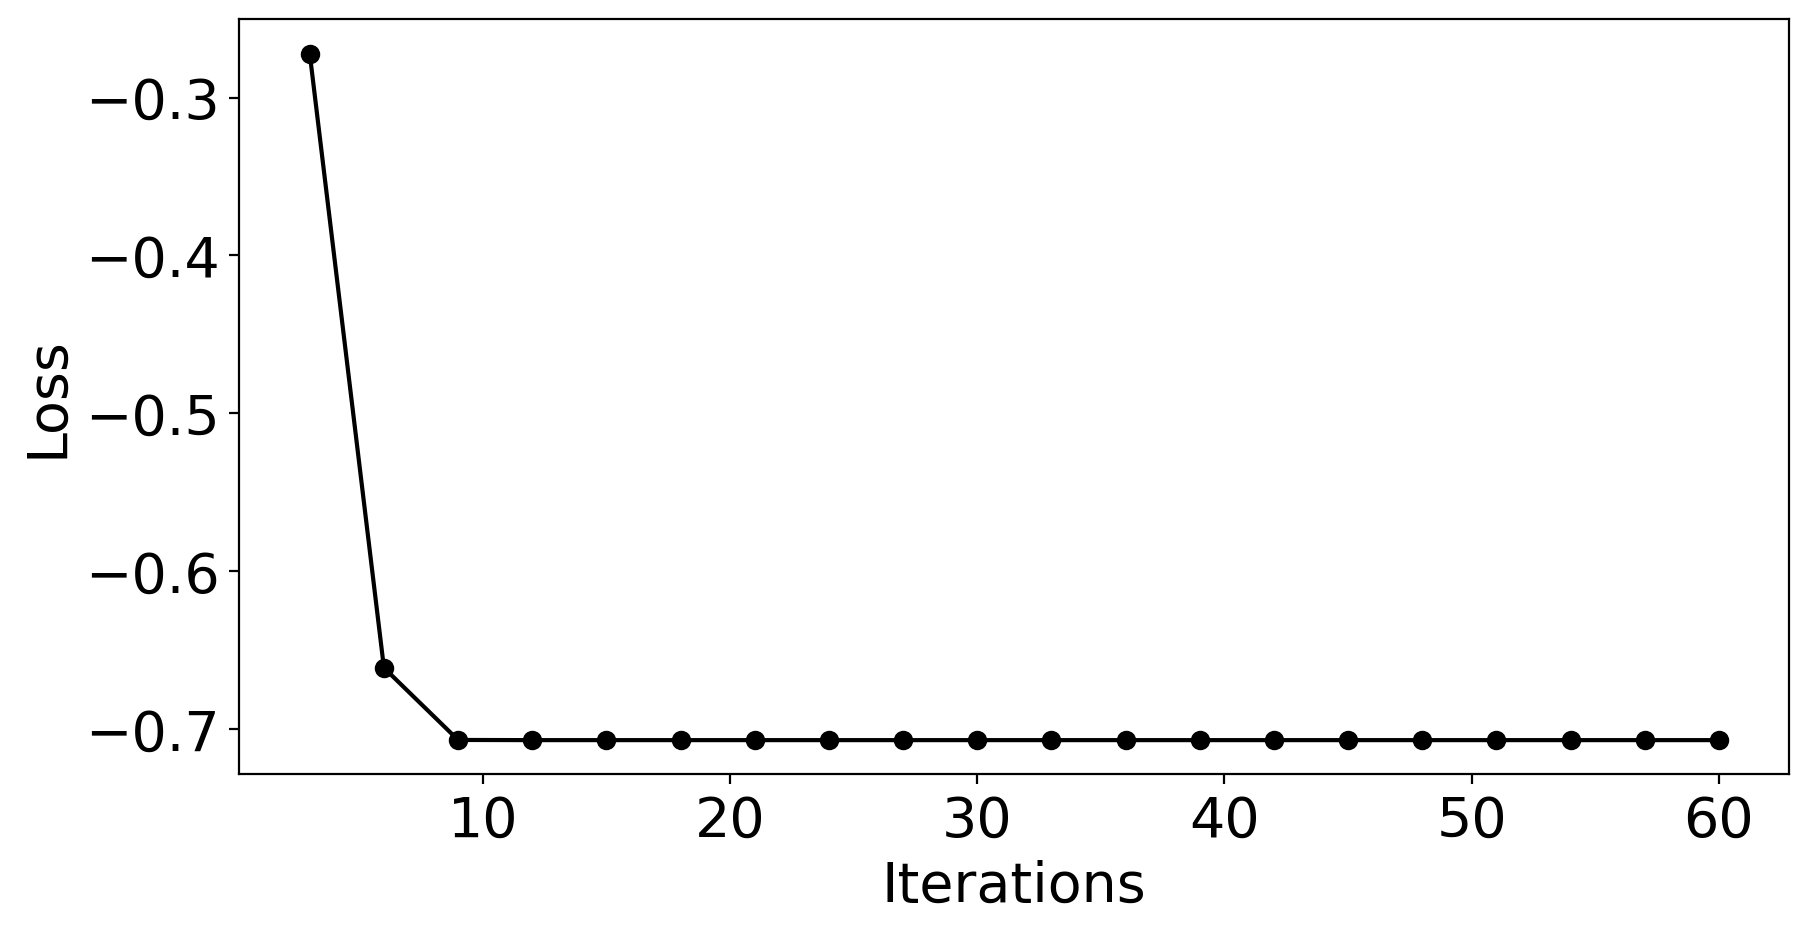

In [26]:
plt.plot(callback[0], TA, c="k", marker="o")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

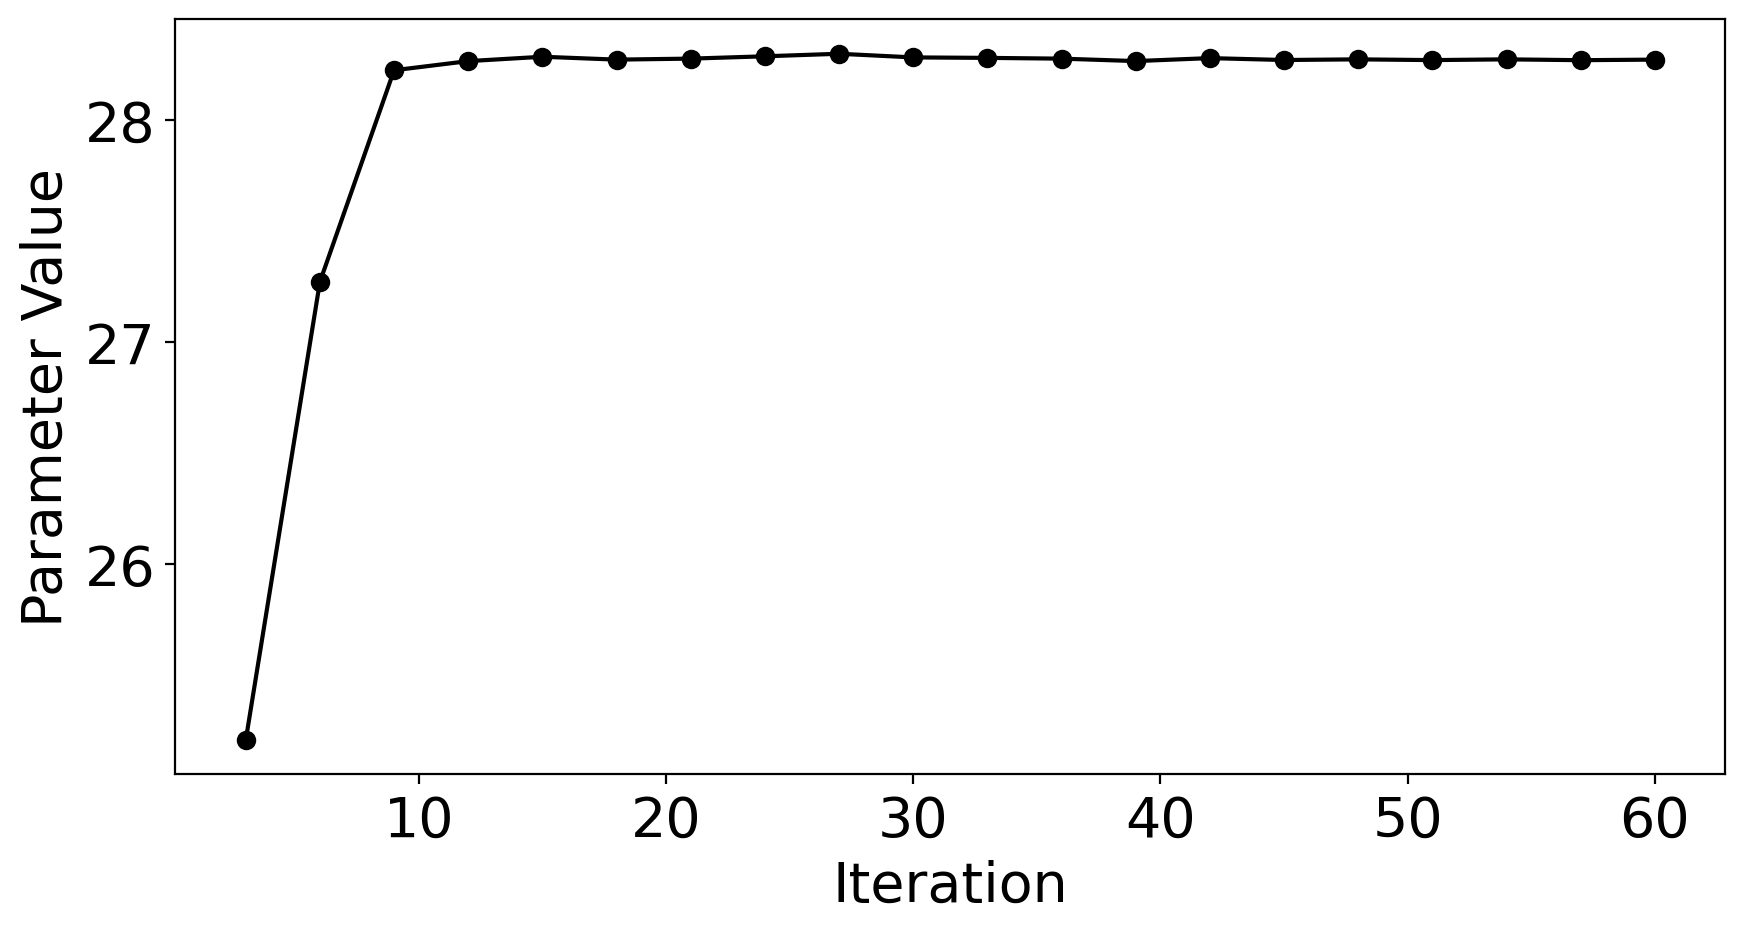

In [ ]:
plt.plot(callback[0], param, c="k", marker="o")
plt.xlabel("Iteration")
plt.ylabel("Parameter Value")
plt.show()

Many optimization runs

In [27]:
def replace_better_callback(cb_qkt_new, cb_qkt_old):
  if(cb_qkt_new[2][-1] < cb_qkt_old[2][-1]):
    #print('new callback is better!')
    return(cb_qkt_new)
  else:
    #print('old callback is better!')
    return(cb_qkt_old)

In [28]:
def run_optimizations(runs = 10, max_init=100, maxiter = 20, learning_rate = 10.0, perturbation = 1.0):
  for i in range(runs):
    initial_point = [max_init*np.random.rand()]
    spsa = SPSA(maxiter=maxiter, callback=cb_qkt.callback, learning_rate=learning_rate, perturbation=perturbation)
    result = spsa.optimize(1, loss, initial_point=initial_point)
    callback = cb_qkt.get_callback_data()
    if(i==0): best_callback = copy.deepcopy(callback)
    best_callback = copy.deepcopy(replace_better_callback(callback, best_callback))
    print('initial_point: ', initial_point)
    print('end loss: ', callback[2][-1])
    print('--------------------------------')
  print('Best loss: ', best_callback[2][-1])
  return(best_callback)


In [29]:
optimized_callback = run_optimizations(runs= 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The SPSA.optimize method is deprecated as of Qiskit Terra 0.21.0 and will be removed no sooner than 3 months after the release date. Instead, use SPSA.minimize as a replacement, which supports the same arguments but follows the interface of scipy.optimize and returns a complete result object containing additional information.
  """


initial_point:  [94.54982288296188]
end loss:  -0.03868555638933077
--------------------------------
initial_point:  [20.17661700831379]
end loss:  -0.04382681552479297
--------------------------------
initial_point:  [46.36333882192767]
end loss:  -0.009924304378591046
--------------------------------
initial_point:  [28.4973287700529]
end loss:  -0.7071067811865477
--------------------------------
initial_point:  [65.40129914355855]
end loss:  -0.013276813866728384
--------------------------------
Best loss:  -0.7071067811865477


In [30]:
TA = optimized_callback[2]
param = optimized_callback[1]
print("Starting parameter: ", initial_point[0], "\nEnd parameter: ", param[-1], "\nIdeal value: ", np.pi*N, "\nLoss: ", TA[-1] , "\nIdeal loss: ", loss(np.pi*N))

Starting parameter:  24.03318379996192 
End parameter:  [28.27635058] 
Ideal value:  28.274333882308138 
Loss:  -0.7071067811865477 
Ideal loss:  -0.7071067811865477


array([28.27635058])

Loss function

In [ ]:
startpoint = 0
endpoint = 2*np.pi*N
points_number = 200
param_test = np.linspace(startpoint,endpoint, points_number)

In [ ]:
Target_a = []
for item in param_test:
    Target_a.append(-loss(item))

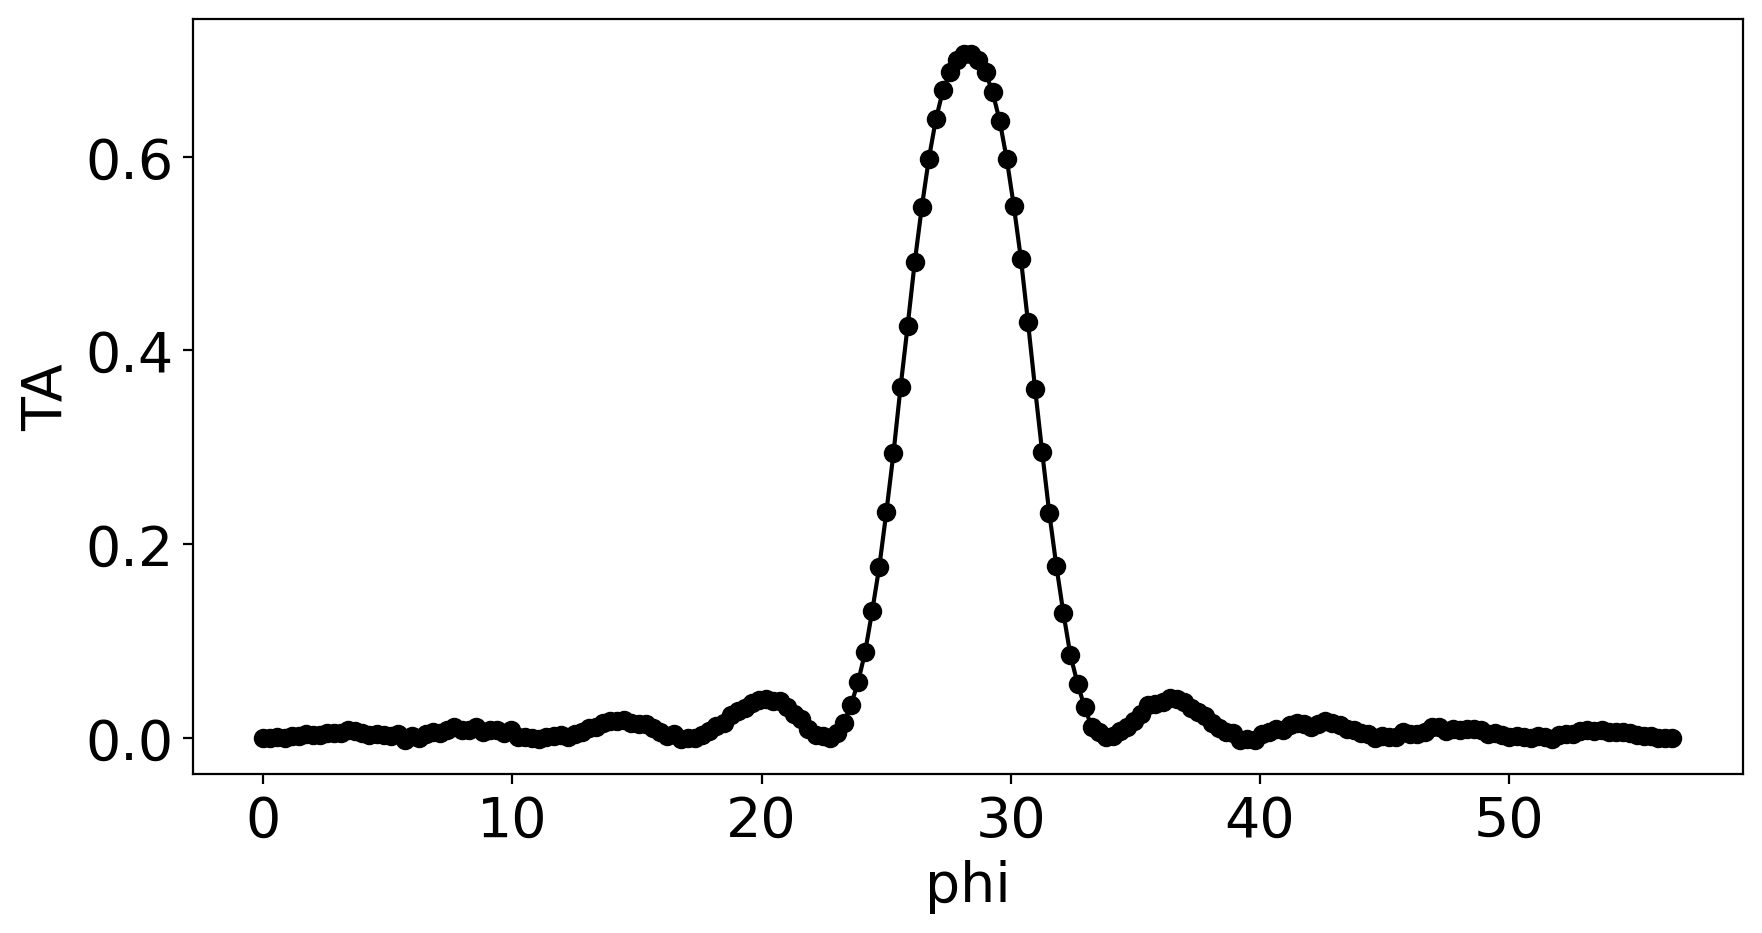

In [ ]:
plt.plot(param_test, Target_a, c="k", marker="o")
plt.xlabel("phi")
plt.ylabel("TA")
plt.show()

Kernel characteristics

In [ ]:
Kt = get_kernel(x, np.pi)

In [ ]:
Kt = get_kernel(x, N*np.pi)
Kt

array([[1., 0., 1., 0., 1., 0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1., 0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1., 0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1., 0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1., 0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0., 1., 0., 1., 0., 1.]])

In [ ]:
def kernel_2_list(K):
  l = []
  n = K.shape[0]
  for i in range(n):
    for j in range(i):
      l.append(K[j,i])
  return(l)

def kernel_2_list_old(K):
  K = np.triu(K, k = 1)
  return(K[K != 0])

(array([25.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 20.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

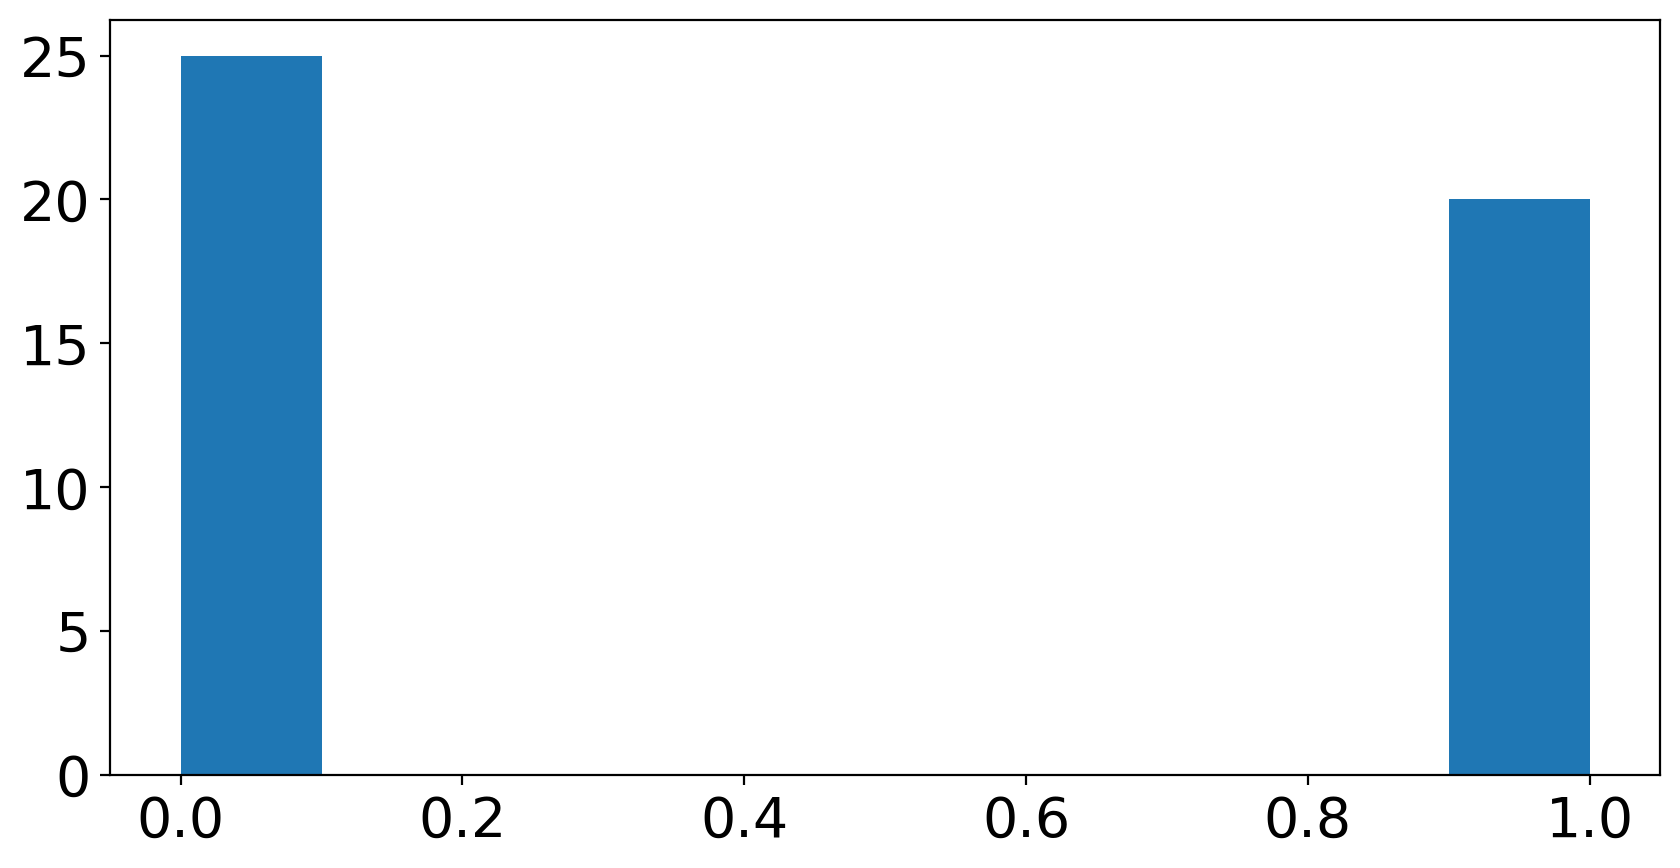

In [ ]:
plt.hist(kernel_2_list(Kt))